# Metadata and Clustering Results Exploration

## Import libraries for analysis

In [4]:
# Built-in libraries
import re
import random

# NumPy, SciPy and Pandas
import numpy as np
from scipy.stats import gaussian_kde
import pandas as pd

# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# JoyPy
import joypy

In [3]:
profiles = pd.read_csv('final_profiles.csv')

/Users/yangxiya/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Explore clustering results for individual buildings
* profiles should contain the clustering labels in the *cluster* column
* may throw error due to failure to smooth profiles (buildings may not have profiles or have single profile in some clusters)

Exploring 5371...


/Users/yangxiya/anaconda3/lib/python3.5/site-packages/pandas/core/generic.py:3110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


Text(0,0.5,'cluster')

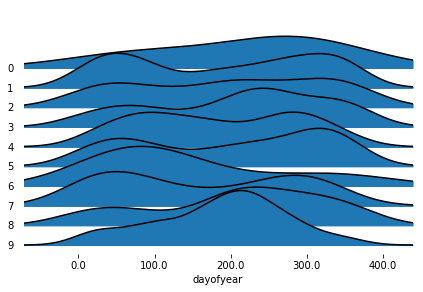

In [5]:
def get_random_building(profiles):
    return random.choice(profiles.drop_duplicates('Building').Building.tolist())

a_building = get_random_building(profiles)
print('Exploring %s...' % a_building)

a_building_profile = profiles.loc[profiles.Building == a_building, :]
a_building_profile.cluster = a_building_profile.cluster.map(lambda x: str(x))
fig, axes = joypy.joyplot(a_building_profile, column=['dayofyear', 'cluster'], by='cluster')
plt.xlabel('dayofyear')
plt.ylabel('cluster')

### Explore clustering results for different categorical variables
* plots are saved to final_plots/kmeans/clustering_breakdown directory
* change directory in the second code block below to save to a different directory

In [6]:
def get_value_counts(algorithm_name, n_cluster, combined_profiles, by='cluster', category='Industry'):
    def helper(col, by=by, proportion=True):
        '''Plots a horizontal stacked bar chart
        col: name of the field to be plotted
        by: which to split the data into subgroups on (cluster or value)
        proportion: show proportion or actual counts
        '''
        if by == 'cluster':
            x_label = 'cluster'
            y_label = col
        elif by == 'value':
            x_label = col
            y_label = 'cluster'
        else:
            raise Exception('Invalid by = %s' % by)
        cluster_stacked_vals = {}
        cluster_stacked = {}
        col_vals = set()
        for c in combined_profiles[y_label].unique():
            cluster_stacked_vals[c] = {}
            cluster_col = combined_profiles.loc[combined_profiles[y_label] == c, x_label]
            val_counts = cluster_col.value_counts()
            for val in val_counts.index:
                col_vals.add(val)
                _count = val_counts[val]
                cluster_stacked_vals[c][val] = _count
        col_vals = list(col_vals)
        for c in cluster_stacked_vals:
            cluster_stacked[c] = []
            v_counts = cluster_stacked_vals[c]
            for col_val in col_vals:
                if col_val in v_counts:
                    cluster_stacked[c].append(v_counts[col_val])
                else:
                    cluster_stacked[c].append(0)
        pd_cluster_stacked = pd.DataFrame.from_dict(cluster_stacked)
        pd_cluster_stacked.index = col_vals
        if proportion:
            for i in range(pd_cluster_stacked.shape[0]):
                total_count = pd_cluster_stacked.iloc[i, :].sum()
                for j in range(pd_cluster_stacked.shape[1]):
                    pd_cluster_stacked.iloc[i, j] = pd_cluster_stacked.iloc[i, j] / total_count
        return pd_cluster_stacked

    return helper(category)

In [12]:
plot_dict = {}

for category in ['Industry', 'Subindustry', 'dateflag', 'PSU', 'Timezone', 'Climatezone']:
    for k in range(2,11):
        profiles['cluster'] = np.load('./final_labels/kmeans/s1k%d.npy' % k)
        plot_dict[k] = get_value_counts(None, None, profiles, by='value', category=category)

    for class_label in plot_dict[2].index:
        plot_mat = np.zeros((9, 10))
        for k in range(2,11):
            plot_mat[k-2, :k] = sorted(plot_dict[k].loc[class_label, :])[::-1]
        plot_df = pd.DataFrame(plot_mat, index=range(2,11)).loc[::-1, :]
        plot_df.plot(kind='barh', stacked=True, legend=False)
        plt.xlabel(class_label)
        plt.ylabel('k')
        plt.title('Clustering Breakdown by %s' %category)
        
        plt.savefig('final_plots/kmeans/clustering_breakdown/%s/%s.png' % (category, re.sub('/', '_', str(class_label))), bbox_inches='tight')
        plt.close()

## Metadata density exploration

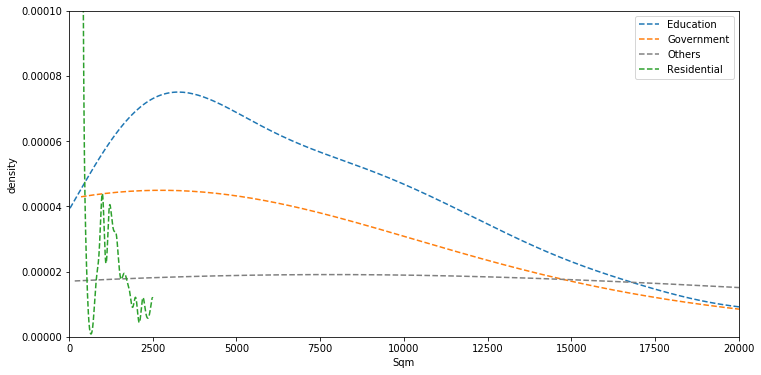

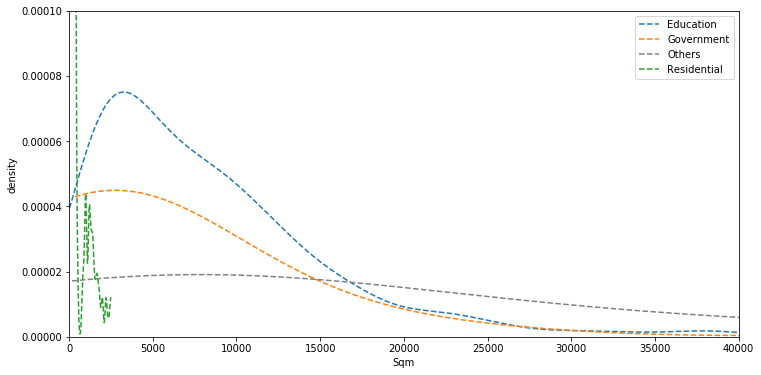

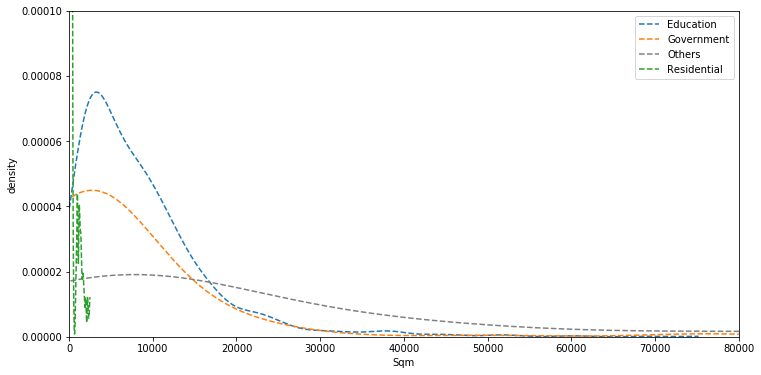

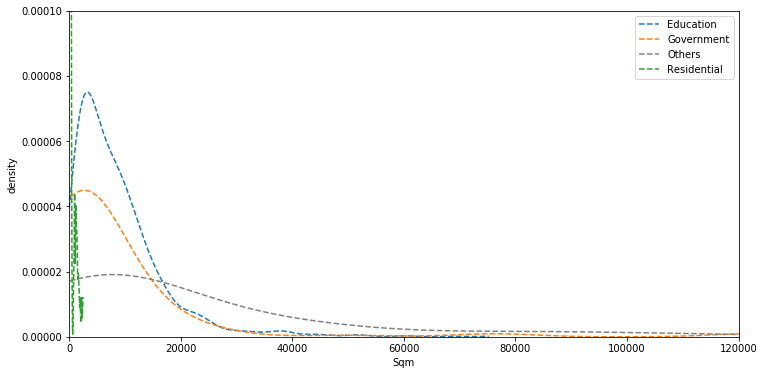

In [15]:
def plot_continuous(numerical_var, categorical_var, x_range, y_range):
    plt.figure(figsize=(12,6))
    values = sorted(profiles[categorical_var].unique().tolist())
    mat = profiles.drop_duplicates(['Dataset', 'Building'])[[categorical_var, numerical_var]].as_matrix()

    plt.figure(figsize=(12,6))
    for v in values:
        selected = mat[mat[:, 0] == v, 1]
        kernel = gaussian_kde(selected.astype('float64'))
        interval = np.linspace(selected.min(), selected.max(), 1000)
        interpolated = kernel.evaluate(interval)
        if v == 'Others':
            plt.plot(interval, interpolated, '--', c='gray', label=v)
        else:
            plt.plot(interval, interpolated, '--', label=v)
    plt.ylim(x_range)
    plt.xlim(y_range)
    plt.xlabel(numerical_var)
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.close()

plot_continuous('Sqm', 'Industry', [0,.0001], [0,20000])
plot_continuous('Sqm', 'Industry', [0,.0001], [0,40000])
plot_continuous('Sqm', 'Industry', [0,.0001], [0,80000])
plot_continuous('Sqm', 'Industry', [0,.0001], [0,120000])

* show separate plots for residential and non-residential densities

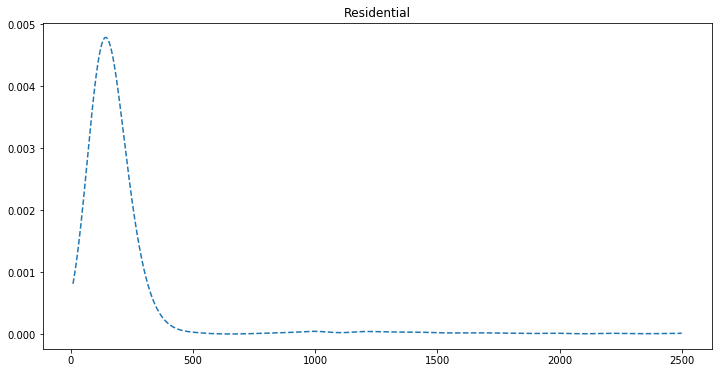

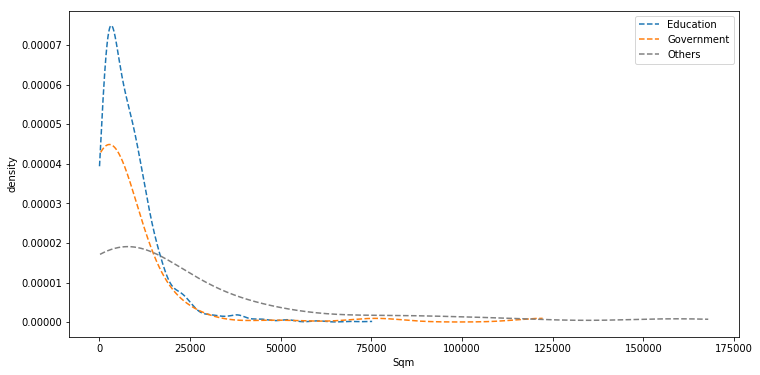

In [17]:
def plot_continuous(numerical_var, categorical_var, x_range, y_range):
    plt.figure(figsize=(12,6))
    values = sorted(profiles[categorical_var].unique().tolist())
    mat = profiles.drop_duplicates(['Dataset', 'Building'])[[categorical_var, numerical_var]].as_matrix()
    
    if 'Residential' in values:
        selected = mat[mat[:, 0] == 'Residential', 1]
        kernel = gaussian_kde(selected.astype('float64'))
        interval = np.linspace(selected.min(), selected.max(), 1000)
        interpolated = kernel.evaluate(interval)
        plt.plot(interval, interpolated, '--')
        plt.title('Residential')
        plt.show()
        plt.close()
        values.remove('Residential')

    plt.figure(figsize=(12,6))
    for v in values:
        selected = mat[mat[:, 0] == v, 1]
        kernel = gaussian_kde(selected.astype('float64'))
        interval = np.linspace(selected.min(), selected.max(), 1000)
        interpolated = kernel.evaluate(interval)
        if v == 'Others':
            plt.plot(interval, interpolated, '--', c='gray', label=v)
        else:
            plt.plot(interval, interpolated, '--', label=v)

    plt.xlabel(numerical_var)
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.close()

plot_continuous('Sqm', 'Industry', [0,.0001], [0,20000])

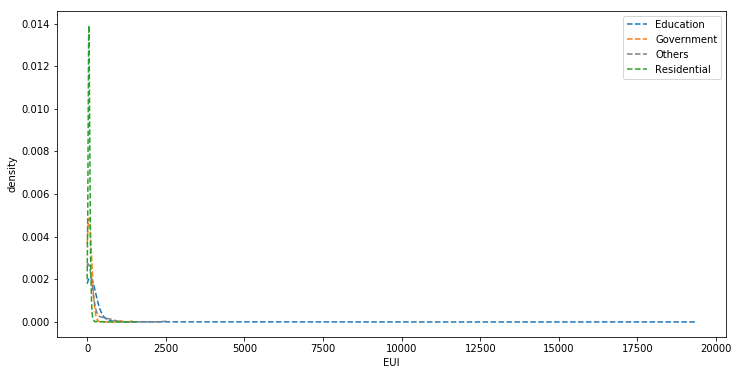

In [19]:
# EUI
def plot_continuous(numerical_var, categorical_var, x_range, y_range):
    plt.figure(figsize=(12,6))
    values = sorted(profiles[categorical_var].unique().tolist())
    mat = profiles.drop_duplicates(['Dataset', 'Building'])[[categorical_var, numerical_var]].as_matrix()

    plt.figure(figsize=(12,6))
    for v in values:
        selected = mat[mat[:, 0] == v, 1]
        kernel = gaussian_kde(selected.astype('float64'))
        interval = np.linspace(selected.min(), selected.max(), 1000)
        interpolated = kernel.evaluate(interval)
        if v == 'Others':
            plt.plot(interval, interpolated, '--', c='gray', label=v)
        else:
            plt.plot(interval, interpolated, '--', label=v)
    plt.xlabel(numerical_var)
    plt.ylabel('density')
    plt.legend()
    plt.show()
    plt.close()

plot_continuous('EUI', 'Industry', [0,.0001], [0,20000])